depth before 326211.0124886632
100.0
depth after 244462.83059940487

depth before 244462.83059940487
77.12283628707989
depth after 215467.5855359994

depth before 215467.5855359994
26.136718852111596
depth after 206394.449651449

depth before 206394.449651449
7.957697156988792
depth after 203702.78017321136

depth before 203702.78017321136
2.3376348853642983
depth after 202977.43008389045

depth before 202977.43008389045
0.6277142429722753
depth after 203358.628234691



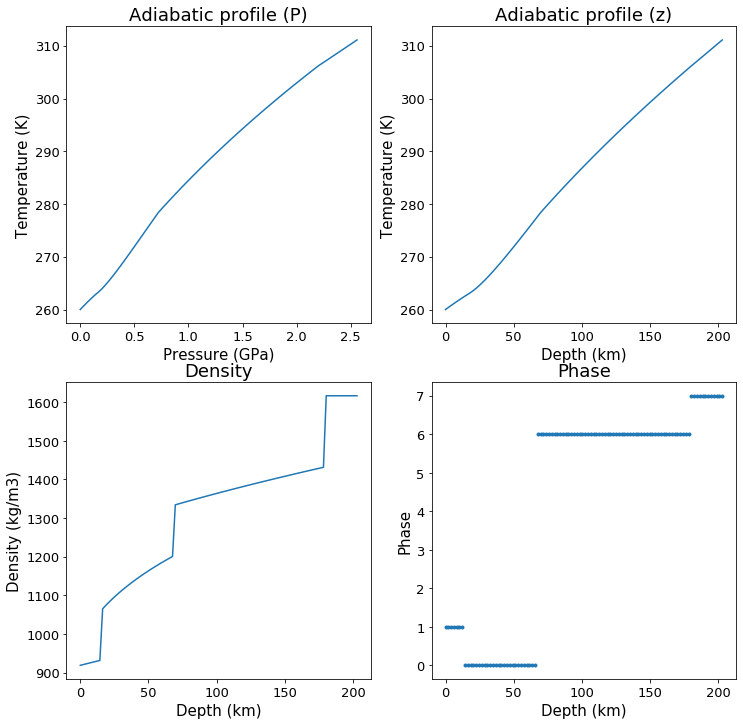

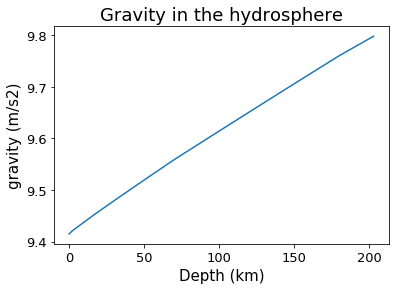

Variable                              Value
----------------------------  -------------
Pressure at surface (bar)       1
Temperature at surface (K)    260
Pressure at HMB (GPa)           2.55846
Temperature at HMB (K)        311.099
Surface Gravity:                9.41479
Planet Radius (m):              6.57336e+06
Hydrosphere Thickness (km)    202.977
Mass of water (kg):             1.39541e+23
Mass of water (Earth Ocean):   99.672
Mass of water (Earth Mass):     0.0233651
Mass difference (%):            0.327969


In [9]:
# HydroSphere v0.6
# Computation of a water-rich planetary body adiabatic profile using SeaFreeze thermodynamics
# with Mass of water as an input
# Baptiste Journaux 2020
import numpy as np
import seafreeze as sf
import matplotlib.pyplot as plt
import time
from tabulate import tabulate
from scipy.optimize import minimize
from numpy import linalg as la

#Europa Ganymede

##### Inputs
P_s = 0.1   # Surface Pressure (MPa);
T_s = 260   # Surface Temperature (K);
Mass_W_i = 100*1.4e21 # Mass of water in kg;
r_b = 1*6370*1e3 #1*6370*1e3  # Radius rocky core (m);
rho_core = 5500 #5500    # density of the rocky core (kg/m3);

##### Resolution
#computation time /profile tools 
res = 100;  # z grid
Mass_it = 5 # Mass convergence iteration: 3-5 is enough (check % Mass difference)
g_it = 2;  # Gravity convergence iteration (3 is enough)

##### Plots and table
plot_flg = 1 # plot flag: 0=no plot; 1=plot
tab_flg = 1 # Table flag: 0=no table; 1=table
gravity_flg = 1 # gravity profile flag: 0=no plot; 1=plot

#### Threshold 
# Threshold mode that terminates the mass loop with given value; 0=diable, 1=enable
mass_thrshd_flg = 0 
# Mass covergence loop threshhold, in percentage
mass_thrshd = 1
# Threshold mode that terminates the gravity loop with given value; 0=diable, 1=enable
grav_thrshd_flg = 0 
# gravity covergence loop threshhold in 2-norm, reasonable factor<0.8, applies only for g_it=2
grav_thrshd = 0.7 

#### New mass-gravity loops caption
# The gravity data set obtained from the first few loops of gravity convergence (2-3 as default) 
# is considered sufficient for the outer mass convergence loop. Given this permission in orde to 
# reduce the time consumption the gravity loop would only be called at the start and end of the 
# mass loop, at a freuency twice (or three times) each, specifically determined by g_it. 

#############################################

# Ice VII approximation
rho_VII = 1.6169e+03
alpha_VII = 2.45e-4
Cp_VII = 3400

# Ice Ih conductivity (Andersson and Akira, 2005) 
def K_Ih(P,T):
    return -2.04104873*P+(632/T+0.38-0.00197*T)

# Rocky/metal core calculation
Mass_core = 4/3*np.pi*r_b**3*rho_core
g_s = 6.67430e-11*Mass_core/r_b**2 # Gravity at the Hydrosphere Mantle Boundary
depth = (Mass_W_i/800/(4/3*np.pi)+r_b**3)**(1/3)-r_b # Depth approximation in m

# Testing factors
massDiff = 100
EnableTest = 1 #0=disable, 1=enable, including time counting, data statistics


# initializing the grids
z = np.arange(0, depth, depth/res)  # depth grid
rho = np.zeros(z.size)  # Density grid
alpha = np.zeros(z.size)  # thermal epansivity grid
Cp = np.zeros(z.size)  # Heat capacity grid
dT_dz = np.zeros(z.size)  # thermal gradient grid
phase = np.zeros(z.size)  # phase grid
T = np.zeros(z.size)  # Temperature grid
P = np.zeros(z.size)  # Pressure grid
grav = np.zeros(z.size) # gravity grid
M_L = np.zeros(z.size) # Mass grid

Mass_WL = 0

while (massDiff > mass_thrshd):
    if EnableTest == 1:
        print("depth before " + str(depth))
        
    # For mass loop the factor being iterated is /depth/
    
    # initializing the grids
    z = np.linspace(0, depth, num=res)  # depth grid
        
    grav[:]=g_s # Constant gravity to start with ## set all elements to g_s
    
    massDiff = np.abs(100*(Mass_W_i-Mass_WL)/Mass_W_i)
    print(massDiff)
    
    # Gravity conversion loop
    for k in range(g_it) if (massDiff==100 or massDiff<mass_thrshd) else range(1): 

        # For gravity loop the factor being iterated is /grav/

        g = np.flip(grav,0)
        PT = np.empty((1,), np.object)
        PT[0] = (P_s, T_s)
        #phase_ssolution = sf.whichphase(PT)  # not necessary 
        if P_s > 2200:
            out.rho = rho_VII
            out.alpha = alpha_VII
            out.Cp = Cp_VII
            phase_s[0] = 7                                      
        else:
            phase_s = sf.whichphase(PT)
            out = sf.seafreeze(PT,sf.phasenum2phase[phase_s[0]]) 

        rho_s = out.rho  # Density at the surface
        alpha_s = out.alpha  # Thermal expansivity at the surface
        Cp_s = out.Cp  # Heat capacity at the surface
        dT_dz_s = alpha_s*g[0]*T_s/Cp_s  # Thermal gradient at the surface
        T[0] = T_s
        P[0] = P_s
        rho[0] = rho_s
        alpha[0] = alpha_s
        Cp[0] = Cp_s
        dT_dz[0] = dT_dz_s
        phase[0] = phase_s[0]

        for i in range(z.size-1):  # Integration with depth
            T[i+1] = T[i] + dT_dz[i] * (z[i+1]-z[i]);
            P[i+1] = P[i] + rho[i] * g[i] * (z[i+1]-z[i])*1e-6;
            PT[0] = (P[i+1],T[i+1])
            if P[i+1] > 2200:
                out.rho = rho_VII
                out.alpha = alpha_VII
                out.Cp = Cp_VII
                phase[i+1] = 7
            else:
                phase[i+1] = sf.whichphase(PT)
                out = sf.seafreeze(PT,sf.phasenum2phase[phase[i]])
            rho[i+1] = out.rho;
            alpha[i+1] = out.alpha;
            Cp[i+1] = out.Cp;
            dT_dz[i+1] = alpha[i+1]*g[i+1]*T[i+1]/Cp[i+1];

        # Gravity in the hydrosphere
        for i in range(1,len(rho)):
            M_L[i]=rho[i]*4/3*np.pi*((r_b+z[i-1]+(depth/res))**3-(r_b+z[i-1])**3)
        Mass_Shells = np.cumsum(np.flip(M_L,0))
        for i in range(len(rho)):    
            grav[i] = 6.67430e-11*(Mass_core+Mass_Shells[i])/(r_b+z[i])**2  

    # Compute Mass
    Mass_WL = np.sum(M_L)
    Mass_diff = Mass_W_i-Mass_WL
    
    
    # depth difference for Mass convergence
    depth_diff = (np.abs(Mass_diff)/(np.mean(rho)*1.8)/(4/3*np.pi)+r_b**3)**(1/3)-r_b
    if   Mass_diff > 0:  
        depth = depth + depth_diff
    else:
        depth = depth - depth_diff
    
    if EnableTest == 1:
        print("depth after " + str(depth))
        print()
    

# Compute Mass
E_M_WL = Mass_WL/5.9722e24 # Mass Water Layer in Earth mass
O_M_WL = Mass_WL/1.4e21 # Mass Water Layer in Ocean mass (Earth)
        
    
if plot_flg == 1:  
    font = {'family' : 'normal',
            'size'   : 15}

    plt.rc('font', **font)
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13) 
    
    
    fig = plt.figure(figsize=(12,12))
    plt.subplots_adjust(wspace=0.2 , hspace=0.2)
    plt.subplot(221)
    plt.xlabel('Pressure (GPa)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (P)')
    plt.plot(P*1e-3, T, '-')

    plt.subplot(222) 
    plt.xlabel('Depth (km)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (z)')
    plt.plot(z*1e-3, T, '-')

    plt.subplot(223)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Density (kg/m3)')
    plt.title('Density')
    plt.plot(z*1e-3, rho, '-')

    plt.subplot(224)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Phase')
    plt.title('Phase')
    plt.plot(z*1e-3, phase, '.')
    
    
    plt.show()
    
    # plot gravity
    plt.xlabel('Depth (km)')
    plt.ylabel('gravity (m/s2)')
    plt.title('Gravity in the hydrosphere')
    plt.plot(z*1e-3, np.flip(grav,0), '-')
    plt.show()




if tab_flg == 1:
    print(tabulate([['Pressure at surface (bar)', P_s*1e1],
               ['Temperature at surface (K)', T_s],
               ['Pressure at HMB (GPa)', max(P)*1e-3],
               ['Temperature at HMB (K)', max(T)],
               ['Surface Gravity:', grav[-1]],
               ['Planet Radius (m):', r_b+depth],
               ['Hydrosphere Thickness (km)', z[-1]*1e-3],
               ['Mass of water (kg):', Mass_WL],
               ['Mass of water (Earth Ocean):', O_M_WL],
               ['Mass of water (Earth Mass):', E_M_WL],
               ['Mass difference (%):', Mass_diff/Mass_W_i*100]],
               headers=['Variable', 'Value']))


In [ ]:
T_test=np.linspace(40,273.15,100)
K = 632/T_test+0.38-0.00197*T_test

plt.xlabel('Temperature (K)')
plt.ylabel('K')
plt.plot(T_test, K, '-')
plt.show()

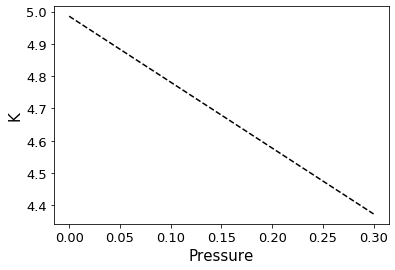

In [25]:
P_test=np.linspace(0,.3,100)
T_t=130
plt.plot(P_test, -2.04104873*P_test+(632/T_t+0.38-0.00197*T_t), '--k') 
plt.xlabel('Pressure')
plt.ylabel('K')
plt.show()

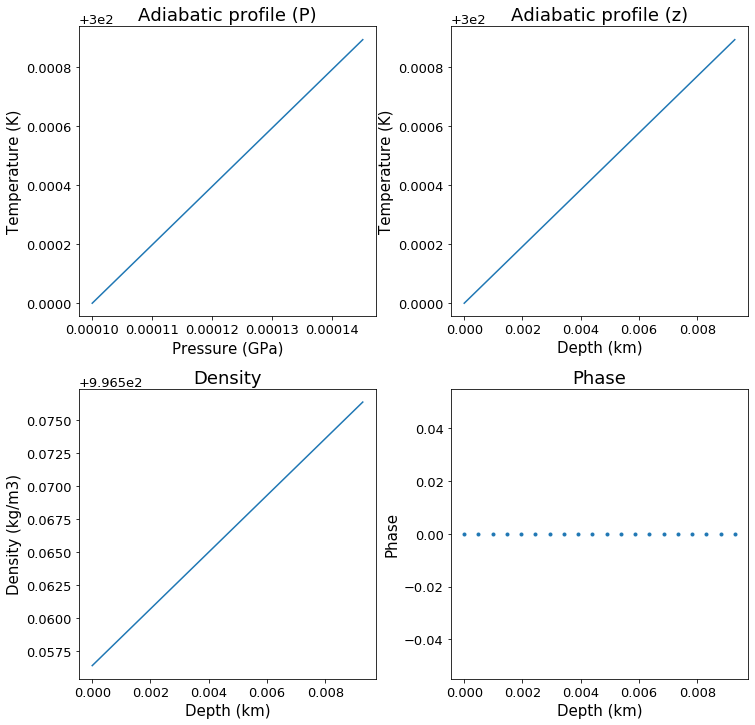

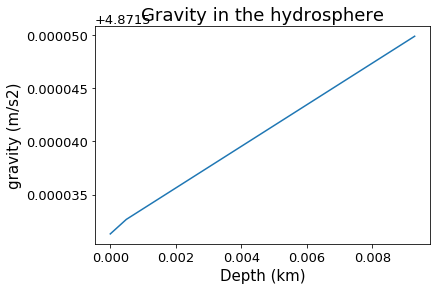

In [13]:
if plot_flg == 1:
    font = {'family' : 'normal',
        'size'   : 15}

    plt.rc('font', **font)
    plt.rc('xtick', labelsize=13) 
    plt.rc('ytick', labelsize=13) 
    
    fig= plt.figure(figsize=(12,12))
    plt.subplots_adjust(wspace=0.25 , hspace=0.25)
    plt.subplot(221)
    plt.xlabel('Pressure (GPa)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (P)')
    plt.plot(P*1e-3, T, '-')

    plt.subplot(222) 
    plt.xlabel('Depth (km)')
    plt.ylabel('Temperature (K)')
    plt.title('Adiabatic profile (z)')
    plt.plot(z*1e-3, T, '-')

    plt.subplot(223)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Density (kg/m3)')
    plt.title('Density')
    plt.plot(z*1e-3, rho, '-')

    plt.subplot(224)  
    plt.xlabel('Depth (km)')
    plt.ylabel('Phase')
    plt.title('Phase')
    plt.plot(z*1e-3, phase, '.')
    
    
    plt.show()
    
    # plot gravity
    plt.xlabel('Depth (km)')
    plt.ylabel('gravity (m/s2)')
    plt.title('Gravity in the hydrosphere')
    plt.plot(z*1e-3, np.flip(grav,0), '-')
    plt.show()